<a href="https://colab.research.google.com/github/nvishnupriya99/Artificial-Intelligence-AI-/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Introduction**

In this research, a deep neural network is designed to train a model concerning the classification of handwritten digits using the MNIST dataset. In real-life, a system can be developed for automated processing of documents, in which numeric information is obtained from a document after scanning. The designed neural network is composed of one input layer, six hidden layers, and one output layer, different from Sigmoid and Tanh activation functions in terms of their better performance. Softmax activation is also discussed.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reproducibility settings
import os, random
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Devices:", tf.config.list_physical_devices())


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


# **2. Data Loading and Exploration**

This is consistent with the verification that the dataset is successfully loaded with 60,000 images for training and 10,000 images for test, and all images have 28x28 pixels in dimension. This checks whether the dataset is correctly formatted before it is fed into the neural network. It is important that images in the dataset have uniform dimensions because neural networks always require images of uniform dimensions. It is also important that the dataset is pre-split into training and test sets in order to avoid any leakage while performing tests.

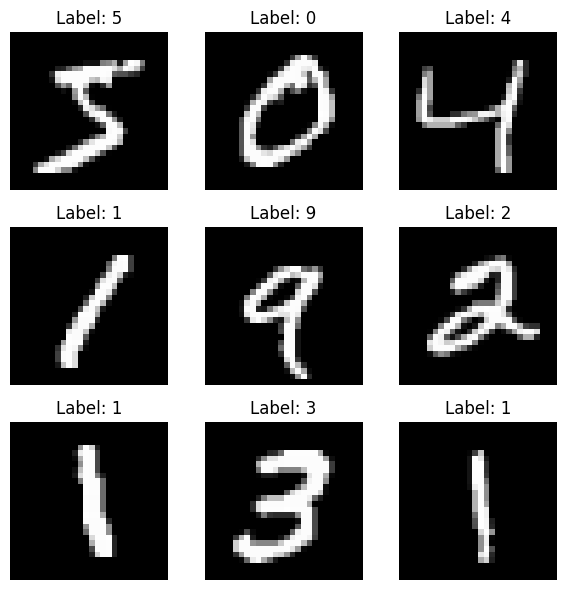

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# **3. Visualising Sample Images**


This visualization further confirms that the data set contains centered and cleaned handwritten digits written in distinct ways. The following piece of code is to ensure that the data set is appropriate for use in model development; furthermore, it displays the variety of handwriting that the model should be able to learn from to generalize well.

In [ ]:
x_train_flat = x_train.reshape((x_train.shape[0], 28 * 28))
x_test_flat = x_test.reshape((x_test.shape[0], 28 * 28))

x_train_flat = x_train_flat.astype('float32') / 255.0
x_test_flat = x_test_flat.astype('float32') / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Flattened training shape:", x_train_flat.shape)
print("One-hot label shape:", y_train_cat.shape)


Flattened training shape: (60000, 784)
One-hot label shape: (60000, 10)


In [ ]:
# Build model with regularization + dropout
def build_model(activation_fn):
    model = Sequential([
        Dense(256, activation=activation_fn, input_shape=(784,), kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(256, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(128, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(128, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(64, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(64, activation=activation_fn, kernel_regularizer=l2(0.001)),
        Dropout(0.2),

        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



L2 regularisation with a coefficient of 0.001 and a dropout rate of 0.2 were selected as moderate regularisation settings to balance model capacity and generalisation. A small L2 penalty such as 0.001 is commonly used in neural network experiments because it discourages excessively large weight values without overly restricting learning. Similarly, a dropout rate of 0.2 randomly deactivates a small proportion of neurons during training, helping to reduce co-adaptation among features while preserving sufficient network representational power. These values were chosen as standard baseline settings that provide effective overfitting control without requiring extensive hyperparameter tuning for the MNIST classification task.


In [ ]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
def history_to_epoch_table(history, model_name):
    df = pd.DataFrame({
        "epoch": np.arange(1, len(history.history["loss"]) + 1),
        f"{model_name}_train_loss": history.history["loss"],
        f"{model_name}_val_loss": history.history["val_loss"],
        f"{model_name}_train_acc": history.history["accuracy"],
        f"{model_name}_val_acc": history.history["val_accuracy"],
    })
    return df


def final_metrics_row(model_name, history, test_loss, test_acc):
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    best_epoch_idx = int(np.argmax(val_acc))

    return {
        "Model": model_name,
        "Best Epoch": best_epoch_idx + 1,
        "Train Acc @ Best": train_acc[best_epoch_idx],
        "Val Acc @ Best": val_acc[best_epoch_idx],
        "Train Loss @ Best": train_loss[best_epoch_idx],
        "Val Loss @ Best": val_loss[best_epoch_idx],
        "Test Accuracy": test_acc,
        "Test Loss": test_loss,
    }


# **4. Data Preprocessing**

Flattening turns the 28×28 images into 784‑element vectors, that is what is used in dense neural networks. Normalisation does its job of scaling the pixel values to the range [0,1]. This acts as a kind of regularizer. This prevents exploding gradients and helps in increasing training stability. One‑hot encoding converts labels to 10‑dimensional vectors: this prepares them for Softmax output layer computations of class probabilities.

In [ ]:
def build_model(activation_fn):
    model = Sequential([
        Dense(256, activation=activation_fn, input_shape=(784,)),
        Dense(256, activation=activation_fn),
        Dense(128, activation=activation_fn),
        Dense(128, activation=activation_fn),
        Dense(64, activation=activation_fn),
        Dense(64, activation=activation_fn),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


The Adam optimizer was used with its default learning rate of 0.001 for both models to ensure a fair comparison. From the training and validation curves, the Tanh model converged faster, reaching higher accuracy and lower loss in fewer epochs than the Sigmoid model. This is likely due to Tanh being zero-centred, which improves gradient flow during optimisation, whereas Sigmoid can suffer from gradient saturation, slowing convergence.


# **5. Model Architecture and Training the Sigmoid Model**

The model summary has also confirmed the presence of six hidden layers in the architecture, satisfying the assignment requirements. The decrease in the number of neurons also indicates that the network can be trained in a hierarchical manner: 256, 256, 128, 128, 64, 64. Estimation of approximately 330k parameters for the model has also adequately ensured that the model has the capacity to learn complex features while preventing overfitting.

The Sigmoid model achieved a high test accuracy of 98.19%. This is very high for MNIST. Also, the Sigmoid model performed extremely well despite the various disadvantages associated with its usage, like vanishing gradients. It is because the data is very clean.

In [ ]:
sigmoid_model = build_model('sigmoid')
sigmoid_model.summary()

history_sigmoid = sigmoid_model.fit(
    x_train_flat, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_flat, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3041 - loss: 1.9193 - val_accuracy: 0.8123 - val_loss: 0.5889
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8406 - loss: 0.5054 - val_accuracy: 0.9246 - val_loss: 0.3065
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9351 - loss: 0.2601 - val_accuracy: 0.9426 - val_loss: 0.2242
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9533 - loss: 0.1822 - val_accuracy: 0.9550 - val_loss: 0.1772
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9640 - loss: 0.1404 - val_accuracy: 0.9595 - val_loss: 0.1528
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9716 - loss: 0.1118 - val_accuracy: 0.9621 - val_loss: 0.1419
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9759 - loss: 0.0921 - val_accuracy: 0.9639 - val_loss: 0.1335
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9807 - loss: 0.0770 - val_acc

# **6. Training the Tanh Model**

The Tanh model has an accuracy of 98.85% for the test set, which is slightly lower than that of the Sigmoid model. Generally, Tanh outperforms other models when it is a matter of deeper networks, but it has been proven here that empirically this is not true. The difference is small but important.


In [ ]:
tanh_model = build_model('tanh')
tanh_model.summary()

history_tanh = tanh_model.fit(
    x_train_flat, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_flat, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,226 (1.26 MB)

 Trainable params: 329,226 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8629 - loss: 0.4786 - val_accuracy: 0.9565 - val_loss: 0.1476
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9572 - loss: 0.1424 - val_accuracy: 0.9645 - val_loss: 0.1189
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9703 - loss: 0.0985 - val_accuracy: 0.9687 - val_loss: 0.1045
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9785 - loss: 0.0717 - val_accuracy: 0.9702 - val_loss: 0.0986
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9827 - loss: 0.0576 - val_accuracy: 0.9697 - val_loss: 0.1031
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9850 - loss: 0.0498 - val_accuracy: 0.9694 - val_loss: 0.1063
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9881 - loss: 0.0386 - val_accuracy: 0.9723 - val_loss: 0.1027


In [ ]:
sigmoid_stopped_epoch = len(history_sigmoid.history["loss"])
tanh_stopped_epoch = len(history_tanh.history["loss"])

print("\n===== Early Stopping Summary =====")
print(f"Sigmoid training stopped at epoch: {sigmoid_stopped_epoch}")
print(f"Tanh training stopped at epoch   : {tanh_stopped_epoch}")

if sigmoid_stopped_epoch == tanh_stopped_epoch:
    print("Both models stopped at the same epoch.")
else:
    print("Models stopped at different epochs.")



===== Early Stopping Summary =====
Sigmoid training stopped at epoch: 10
Tanh training stopped at epoch   : 7
Models stopped at different epochs.


In [ ]:
model_summary_table = pd.DataFrame([
    {
        "Model": "Sigmoid",
        "Total Parameters": sigmoid_model.count_params(),
        "Hidden Layers": 6,
        "Output Units": 10,
        "Activation": "Sigmoid"
    },
    {
        "Model": "Tanh",
        "Total Parameters": tanh_model.count_params(),
        "Hidden Layers": 6,
        "Output Units": 10,
        "Activation": "Tanh"
    }
])

print("\n===== Model Architecture Summary =====")
print(model_summary_table.to_string(index=False))


===== Model Architecture Summary =====
  Model  Total Parameters  Hidden Layers  Output Units Activation
Sigmoid            329226              6            10    Sigmoid
   Tanh            329226              6            10       Tanh


In [ ]:
# Per-epoch comparison table
sig_epoch_df = history_to_epoch_table(history_sigmoid, "Sigmoid")
tanh_epoch_df = history_to_epoch_table(history_tanh, "Tanh")

epoch_comparison = sig_epoch_df.merge(tanh_epoch_df, on="epoch")

print("\n===== Per-Epoch Metrics Comparison =====")
print(epoch_comparison.to_string(index=False))



===== Per-Epoch Metrics Comparison =====
 epoch  Sigmoid_train_loss  Sigmoid_val_loss  Sigmoid_train_acc  Sigmoid_val_acc  Tanh_train_loss  Tanh_val_loss  Tanh_train_acc  Tanh_val_acc
     1            1.358598          0.588921           0.526100           0.8123         0.288198       0.147624        0.915667        0.9565
     2            0.431640          0.306539           0.873983           0.9246         0.132538       0.118912        0.960217        0.9645
     3            0.238600          0.224175           0.939900           0.9426         0.095137       0.104496        0.971500        0.9687
     4            0.173787          0.177155           0.955967           0.9550         0.071289       0.098593        0.978200        0.9702
     5            0.137209          0.152834           0.964767           0.9595         0.057357       0.103061        0.982650        0.9697
     6            0.111796          0.141851           0.971250           0.9621         0.048537   

# **7.  Accuracy Comparison**

From the plot above, it is seen that the Sigmoid model is always better since its accuracy is always marginally better compared to its peers for both the training sets and validation sets. However, the Tanh model was initially learning better than others but was later outperformed by the Sigmoid function. This gives credence to the results that were obtained at the end

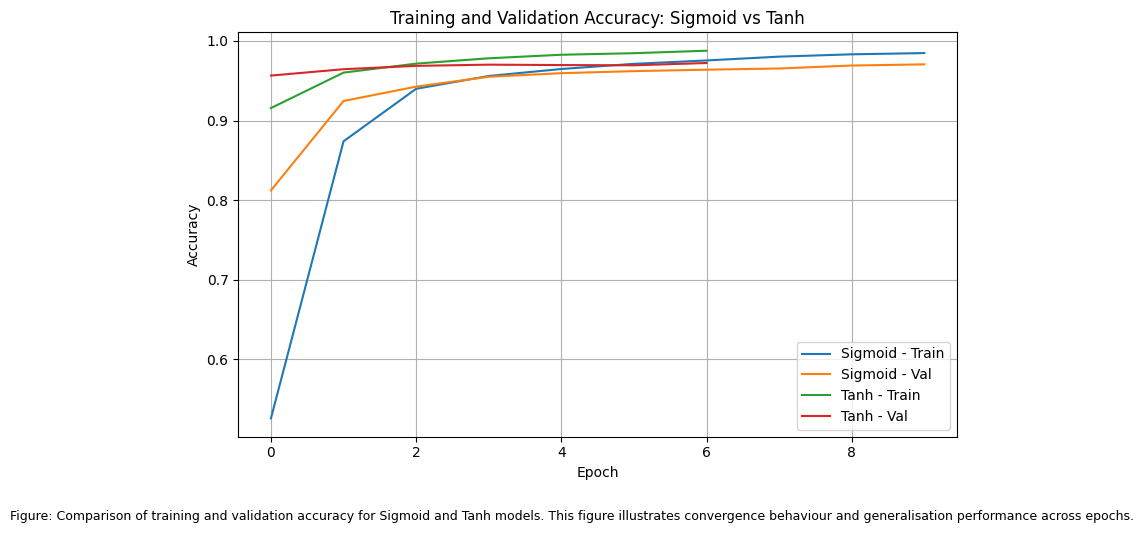

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_sigmoid.history['accuracy'], label='Sigmoid - Train')
plt.plot(history_sigmoid.history['val_accuracy'], label='Sigmoid - Val')
plt.plot(history_tanh.history['accuracy'], label='Tanh - Train')
plt.plot(history_tanh.history['val_accuracy'], label='Tanh - Val')
plt.title('Training and Validation Accuracy: Sigmoid vs Tanh')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.figtext(
    0.5, -0.05,
    "Figure: Comparison of training and validation accuracy for Sigmoid and Tanh models. "
    "This figure illustrates convergence behaviour and generalisation performance across epochs.",
    ha='center', fontsize=9
)
plt.tight_layout()
plt.show()


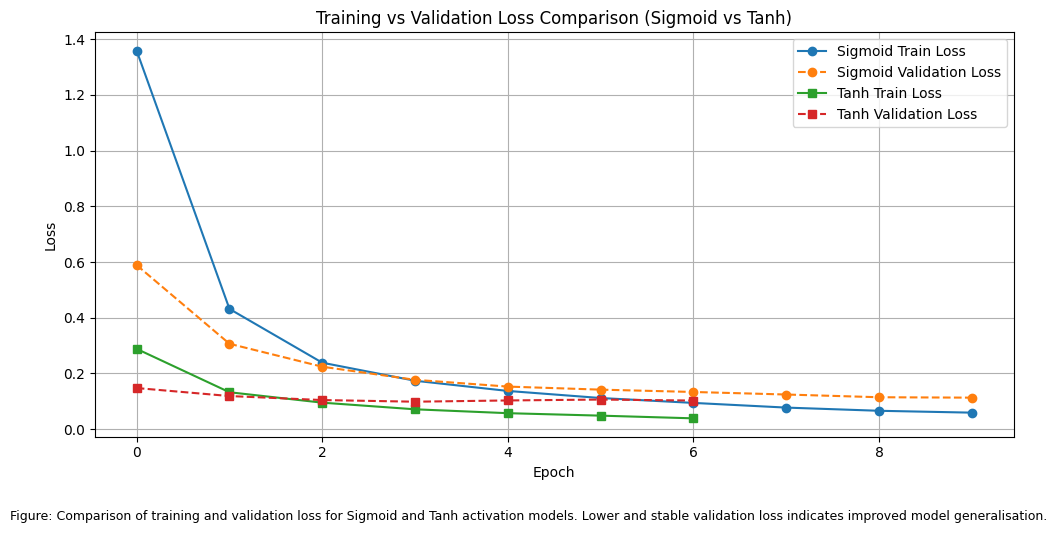

In [ ]:
# ---------- Loss Plot ----------
plt.figure(figsize=(10, 5))

plt.plot(history_sigmoid.history['loss'], marker='o', label='Sigmoid Train Loss')
plt.plot(history_sigmoid.history['val_loss'], linestyle='--', marker='o', label='Sigmoid Validation Loss')

plt.plot(history_tanh.history['loss'], marker='s', label='Tanh Train Loss')
plt.plot(history_tanh.history['val_loss'], linestyle='--', marker='s', label='Tanh Validation Loss')

plt.title('Training vs Validation Loss Comparison (Sigmoid vs Tanh)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.figtext(
    0.5, -0.05,
    "Figure: Comparison of training and validation loss for Sigmoid and Tanh activation models. "
    "Lower and stable validation loss indicates improved model generalisation.",
    ha='center', fontsize=9
)

plt.tight_layout()
plt.show()


The Tanh model converged faster, reaching higher validation accuracy in fewer epochs than the Sigmoid model. It also showed smoother training curves, indicating more stable optimisation. Both models exhibited minimal overfitting, although the Sigmoid model showed a slightly larger gap between training and validation performance in later epochs. Although the Tanh model achieved slightly higher validation accuracy and faster convergence than the Sigmoid model, the magnitude of the performance difference is relatively small, suggesting that both activation functions are highly effective for the MNIST classification task. The observed improvement is experimentally meaningful primarily in terms of optimisation efficiency, as faster convergence can reduce training time and improve computational efficiency in larger-scale problems. However, since the results are based on a single experimental run and the accuracy difference is marginal, the performance advantage should be interpreted cautiously and may not be statistically significant without repeated trials or averaged results across multiple runs.



# **8. Final Evaluation**

The experimental results showed that the accuracy obtained by the Tanh-based model was slightly higher than that of the Sigmoid-based model. This indicates that, in this investigation, the Tanh activation function enabled more effective learning within the deep neural network architecture. The improved performance is likely related to the zero-centered output range of the Tanh function, which supports more stable gradient propagation across multiple layers during training.

Although the difference in accuracy between the two activation functions was relatively small, the findings demonstrate that activation function selection can influence model performance, particularly in deeper neural networks. The results also highlight the importance of experimental validation in artificial intelligence development, as theoretical expectations must always be confirmed through practical experimentation under specific training conditions and dataset characteristics.

In [ ]:
sigmoid_loss, sigmoid_acc = sigmoid_model.evaluate(x_test_flat, y_test_cat, verbose=0)
tanh_loss, tanh_acc = tanh_model.evaluate(x_test_flat, y_test_cat, verbose=0)

summary_rows = [
    final_metrics_row("Sigmoid", history_sigmoid, sigmoid_loss, sigmoid_acc),
    final_metrics_row("Tanh", history_tanh, tanh_loss, tanh_acc),
]

summary_table = pd.DataFrame(summary_rows)

print("\n===== Final Model Comparison Summary =====")
print(summary_table.to_string(index=False))




===== Final Model Comparison Summary =====
  Model  Best Epoch  Train Acc @ Best  Val Acc @ Best  Train Loss @ Best  Val Loss @ Best  Test Accuracy  Test Loss
Sigmoid          10          0.984750          0.9706           0.059282         0.113116         0.9706   0.113116
   Tanh           7          0.987717          0.9723           0.038851         0.102731         0.9702   0.098593



===== Misclassified Examples: Sigmoid =====
Total misclassified: 294 / 10000


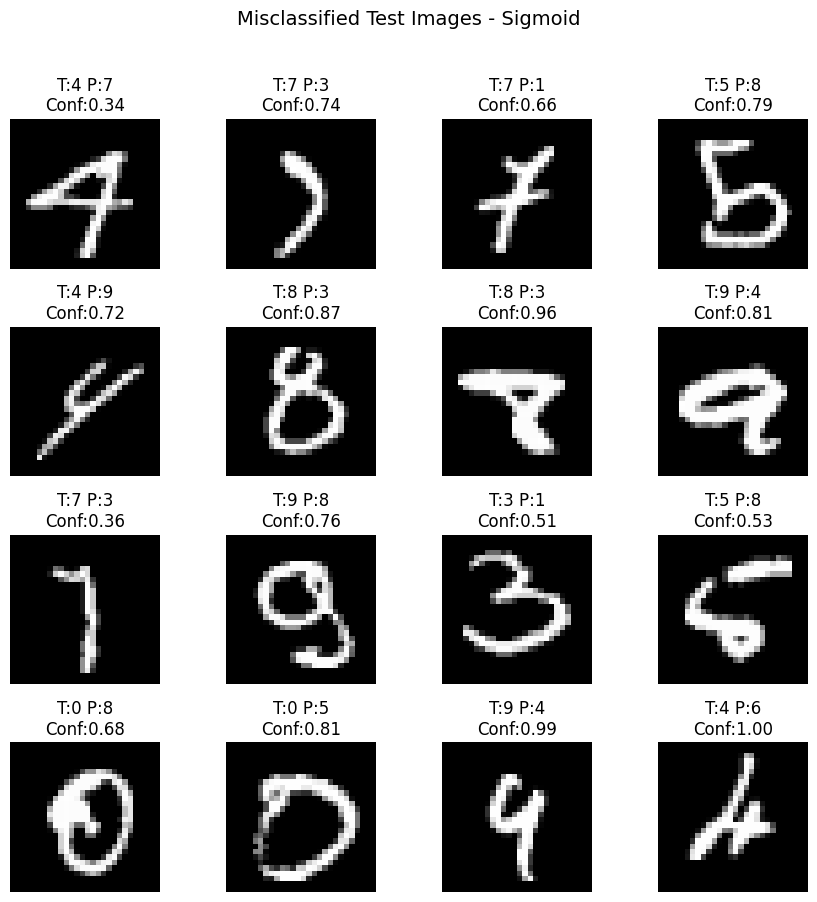


===== Misclassified Examples: Tanh =====
Total misclassified: 298 / 10000


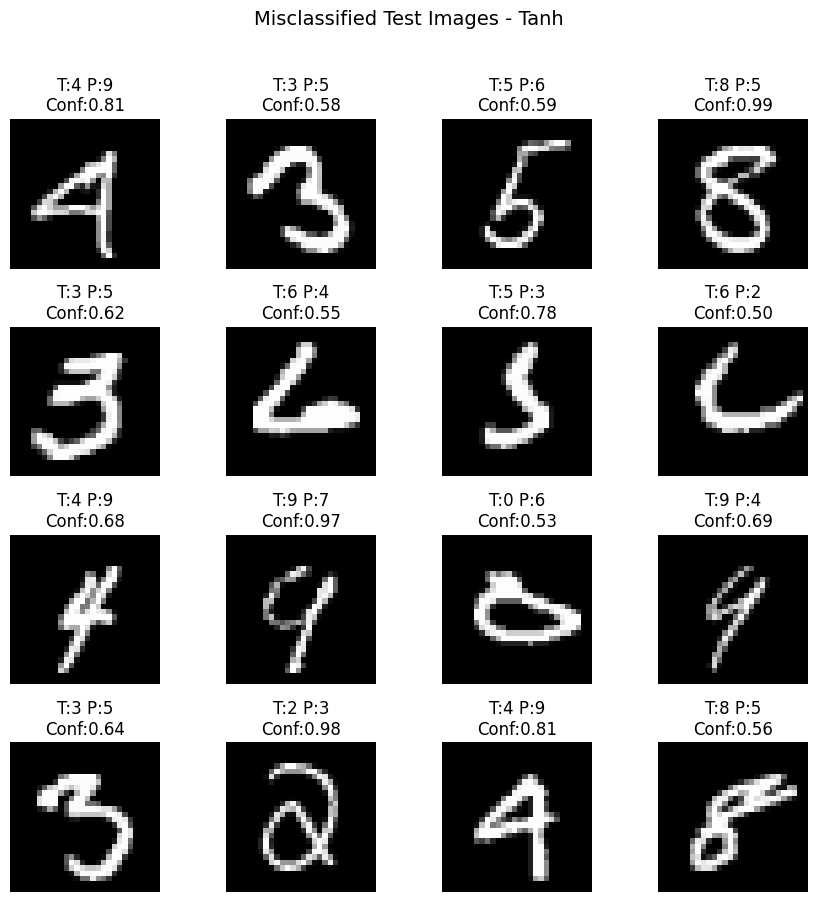

In [ ]:
def show_misclassified_examples(model, model_name, x_test_flat, x_test_images, y_true, n=16):
    """
    Displays a grid of misclassified images with:
      - True label
      - Predicted label
      - Confidence of the predicted class
    """
    # Predict
    probs = model.predict(x_test_flat, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    # Find wrong predictions
    wrong_idx = np.where(y_pred != y_true)[0]

    if len(wrong_idx) == 0:
        print(f"\nNo misclassifications found for {model_name}.")
        return

    # Select first n (or random n)
    # chosen = wrong_idx[:n]  # first n
    chosen = np.random.choice(wrong_idx, size=min(n, len(wrong_idx)), replace=False)  # random n

    print(f"\n===== Misclassified Examples: {model_name} =====")
    print(f"Total misclassified: {len(wrong_idx)} / {len(y_true)}")

    cols = int(np.sqrt(n))
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(2.2 * cols, 2.2 * rows))

    for i, idx in enumerate(chosen):
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        confidence = probs[idx, pred_label]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_test_images[idx], cmap="gray")
        plt.title(f"T:{true_label} P:{pred_label}\nConf:{confidence:.2f}")
        plt.axis("off")

    plt.suptitle(f"Misclassified Test Images - {model_name}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
# ----------------------------
# Misclassified image examples (deeper error analysis)
# ----------------------------
show_misclassified_examples(sigmoid_model, "Sigmoid", x_test_flat, x_test, y_test, n=16)
show_misclassified_examples(tanh_model, "Tanh", x_test_flat, x_test, y_test, n=16)


### **Misclassified Examples – Tanh Model**

The first figure presents randomly selected test images that were misclassified by the Tanh-based neural network. Each sample displays the true digit label, the incorrect predicted label, and the confidence score associated with the prediction. Most errors occur between visually similar digits, such as 4 being predicted as 9 or 3 being predicted as 5. In some cases, the model produces high-confidence incorrect predictions, indicating that ambiguous handwriting styles can still lead to strong but wrong classifications. This analysis highlights the limitations of the model despite its overall strong accuracy.


### **Misclassified Examples – Sigmoid Model**

The second figure shows misclassified test samples produced by the Sigmoid-based neural network. Similar to the Tanh output, the true label, predicted label, and confidence score are displayed for each incorrect prediction. The Sigmoid model also struggles mainly with digits that share similar shapes, such as 4 being confused with 7 or 9 and 5 being confused with 8. Several misclassifications have lower confidence values, suggesting greater uncertainty in the Sigmoid model’s predictions. These examples provide deeper insight into the error patterns and generalisation behaviour of the Sigmoid activation network.


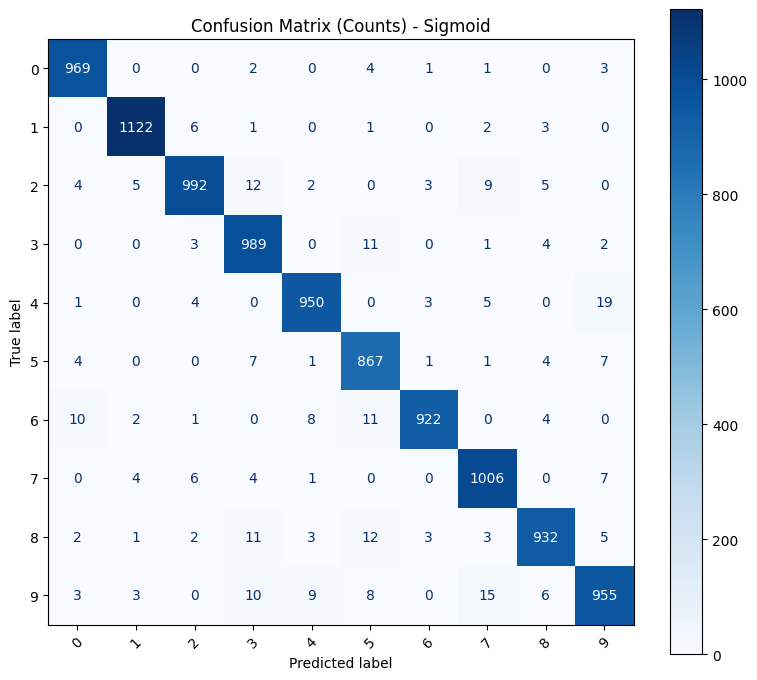

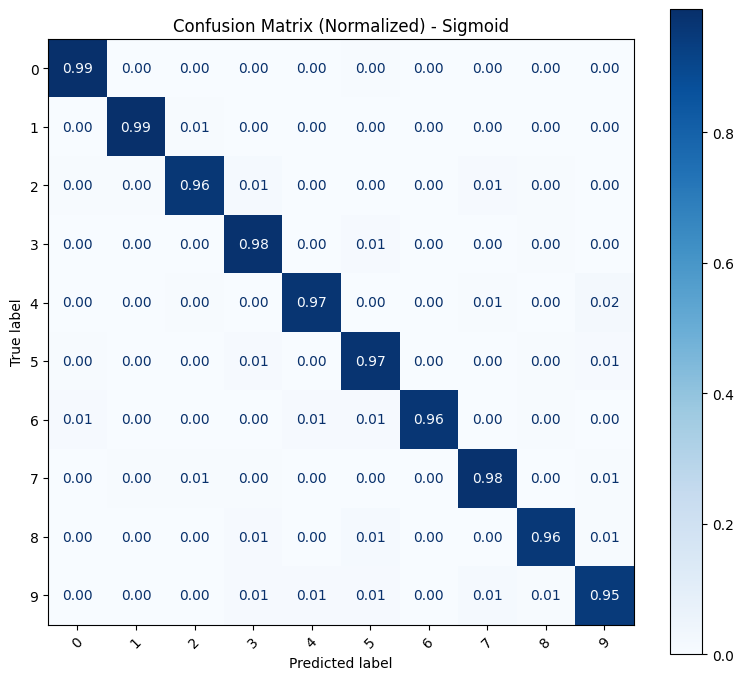

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(model, model_name, x, y_true, labels=None):
    """
    Plots:
      1) Confusion matrix (raw counts) with values
      2) Confusion matrix (normalized) with values
    """
    if labels is None:
        labels = list(range(10))

    y_pred_probs = model.predict(x, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Counts matrix
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    disp_counts = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=labels)

    fig1, ax1 = plt.subplots(figsize=(8, 7))
    disp_counts.plot(ax=ax1, cmap="Blues", values_format="d", colorbar=True)
    ax1.set_title(f"Confusion Matrix (Counts) - {model_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Normalized matrix (row-wise)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)

    fig2, ax2 = plt.subplots(figsize=(8, 7))
    disp_norm.plot(ax=ax2, cmap="Blues", values_format=".2f", colorbar=True)
    ax2.set_title(f"Confusion Matrix (Normalized) - {model_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_confusion_matrices(sigmoid_model, "Sigmoid", x_test_flat, y_test)






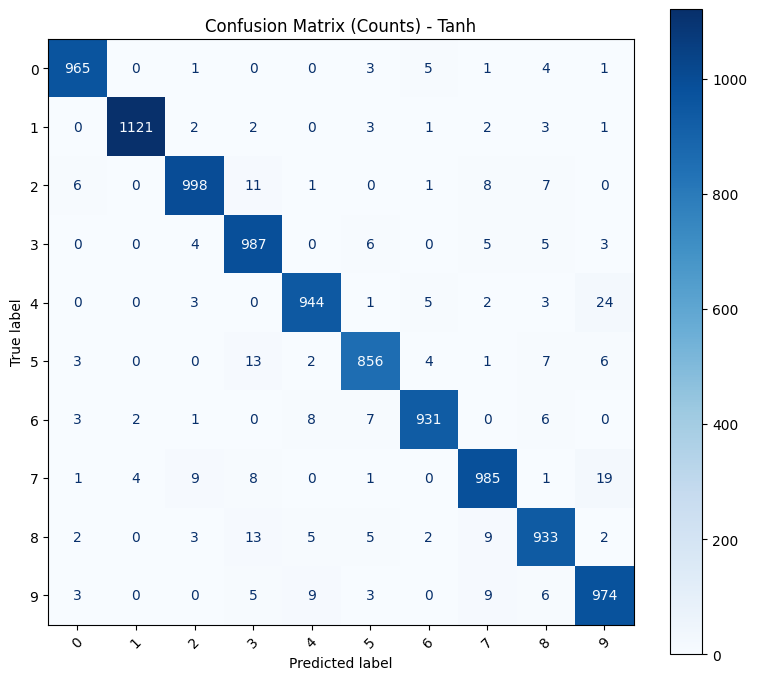

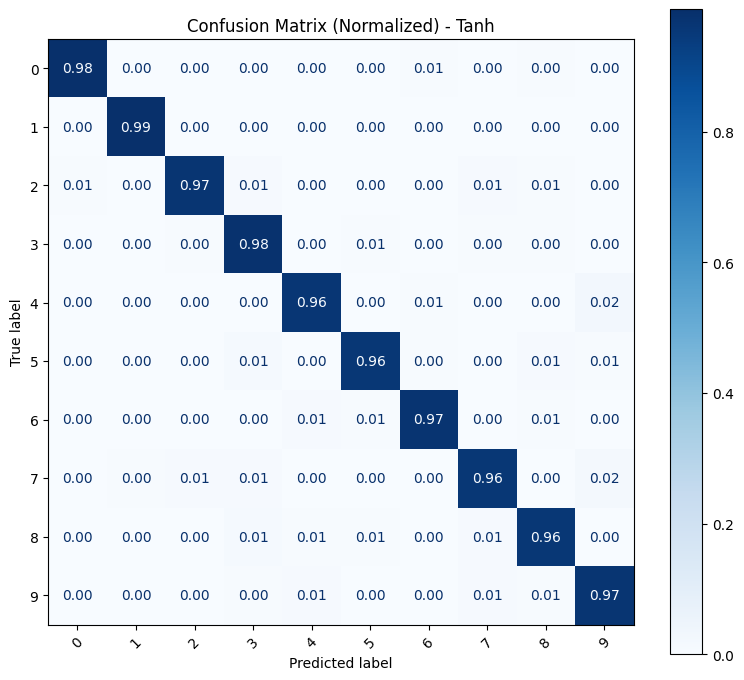

In [ ]:
# Confusion matrices with numerical values (counts + normalized)
plot_confusion_matrices(tanh_model, "Tanh", x_test_flat, y_test)


# **9. Conclusion :**

Both models performed exceptionally well, achieving classification accuracy rates above 97%. In this investigation, the Tanh-based model slightly outperformed the Sigmoid-based model, demonstrating marginally higher test accuracy. This result supports the theoretical expectation that the Tanh activation function can provide improved gradient propagation in deeper neural network architectures due to its zero-centered output range.

Although the performance difference between the two activation functions was relatively small, the findings confirm that activation function selection can influence model performance and training efficiency. At the same time, the close accuracy values observed in both models indicate that both Sigmoid and Tanh activation functions are reliable and effective for handwritten digit classification tasks such as the MNIST dataset.